In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np


In [4]:


def detect_anomalies(target_class_name):
    # Define CIFAR-10 classes
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']
    target_class_index = cifar10_classes.index(target_class_name)

    # Transformations for images
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    # Filter dataset to include only the target class
    train_indices = [i for i, (_, label) in enumerate(trainset) if label == target_class_index]
    test_indices = [i for i, (_, label) in enumerate(testset) if label == target_class_index]

    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64,
                                              shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_subset, batch_size=64,
                                             shuffle=False, num_workers=2)

    # Define Encoder, Generator, and Discriminator networks
    latent_dim = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class Encoder(nn.Module):
        def __init__(self, latent_dim=100):
            super(Encoder, self).__init__()
            self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(256, latent_dim, 4, 1, 0, bias=False),
                nn.Tanh()
            )

        def forward(self, input):
            output = self.main(input)
            return output.view(-1, latent_dim, 1, 1)

    class Generator(nn.Module):
        def __init__(self, latent_dim=100):
            super(Generator, self).__init__()

            self.main = nn.Sequential(
                nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
                nn.Tanh()
            )

        def forward(self, input):
            return self.main(input)

    class Discriminator(nn.Module):
        def __init__(self, latent_dim=100):
            super(Discriminator, self).__init__()

            self.image_net = nn.Sequential(
                nn.Conv2d(3, 64, 4, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(128, 256, 4, 2, 1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Flatten()
            )

            self.latent_net = nn.Sequential(
                nn.Conv2d(latent_dim, 256, 1, 1, 0),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Flatten()
            )

            self.joint_net = nn.Sequential(
                nn.Linear(256 * 4 * 4 + 256 * 1 * 1, 1024),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(1024, 1),
                nn.Sigmoid()
            )

        def forward(self, x, z):
            x_out = self.image_net(x)
            z_out = self.latent_net(z)
            combined = torch.cat([x_out, z_out], dim=1)
            validity = self.joint_net(combined)
            return validity.view(-1)

    encoder = Encoder(latent_dim).to(device)
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator(latent_dim).to(device)

    # Optimizers and loss function
    lr = 0.0002
    beta1 = 0.5

    optimizer_E = optim.Adam(encoder.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    criterion = nn.BCELoss()

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            # Get real images
            real_images, _ = data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Create labels
            real_label = torch.ones(batch_size, device=device)
            fake_label = torch.zeros(batch_size, device=device)

            # Train Discriminator
            discriminator.zero_grad()

            # Encode real images to latent vectors
            encoded_z = encoder(real_images)

            # D(x, E(x))
            output_real = discriminator(real_images, encoded_z.detach())
            loss_D_real = criterion(output_real, real_label)

            # Generate fake images from random latent vectors
            random_z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            generated_images = generator(random_z)

            # D(G(z), z)
            output_fake = discriminator(generated_images.detach(), random_z)
            loss_D_fake = criterion(output_fake, fake_label)

            # Combine losses
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # Train Generator and Encoder
            generator.zero_grad()
            encoder.zero_grad()

            # For Generator and Encoder, labels are real
            output_fake = discriminator(generated_images, random_z)
            loss_G = criterion(output_fake, real_label)

            output_real = discriminator(real_images, encoded_z)
            loss_E = criterion(output_real, fake_label)

            # Combine losses
            loss_GE = (loss_G + loss_E) / 2
            loss_GE.backward()
            optimizer_G.step()
            optimizer_E.step()

            # Print statistics
            if i % 100 == 0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                      % (epoch+1, num_epochs, i, len(trainloader),
                         loss_D.item(), loss_G.item()))

    # Compute reconstruction errors on test set
    test_images = []
    for data in testloader:
        images, _ = data
        test_images.append(images)
    test_images = torch.cat(test_images, dim=0)

    reconstruction_errors = []

    encoder.eval()
    generator.eval()
    with torch.no_grad():
        for i in range(0, len(test_images), 64):
            batch_images = test_images[i:i+64].to(device)
            z = encoder(batch_images)
            recon_images = generator(z)
            errors = torch.mean((batch_images - recon_images) ** 2, dim=[1,2,3])
            reconstruction_errors.append(errors.cpu())
    reconstruction_errors = torch.cat(reconstruction_errors, dim=0)

    # Find anomalies and normals
    sorted_indices = torch.argsort(reconstruction_errors, descending=True)
    N = 15
    anomaly_indices = sorted_indices[:N]
    normal_indices = sorted_indices[-N:]

    anomaly_images = test_images[anomaly_indices]
    normal_images = test_images[normal_indices]

    # Function to unnormalize and display images
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')

    # Plot anomalies
    plt.figure(figsize=(15,9))
    plt.suptitle(f'Anomalies in {target_class_name}')
    grid = make_grid(anomaly_images, nrow=5, padding=2)
    imshow(grid)
    plt.show()

    # Plot normals
    plt.figure(figsize=(15,9))
    plt.suptitle(f'Normals in {target_class_name}')
    grid = make_grid(normal_images, nrow=5, padding=2)
    imshow(grid)
    plt.show()



Files already downloaded and verified
Files already downloaded and verified
[1/5][0/79] Loss_D: 0.7119 Loss_G: 1.6489
[2/5][0/79] Loss_D: 0.0488 Loss_G: 7.2342
[3/5][0/79] Loss_D: 1.0623 Loss_G: 9.1679
[4/5][0/79] Loss_D: 0.2337 Loss_G: 5.7463
[5/5][0/79] Loss_D: 0.3504 Loss_G: 5.1736


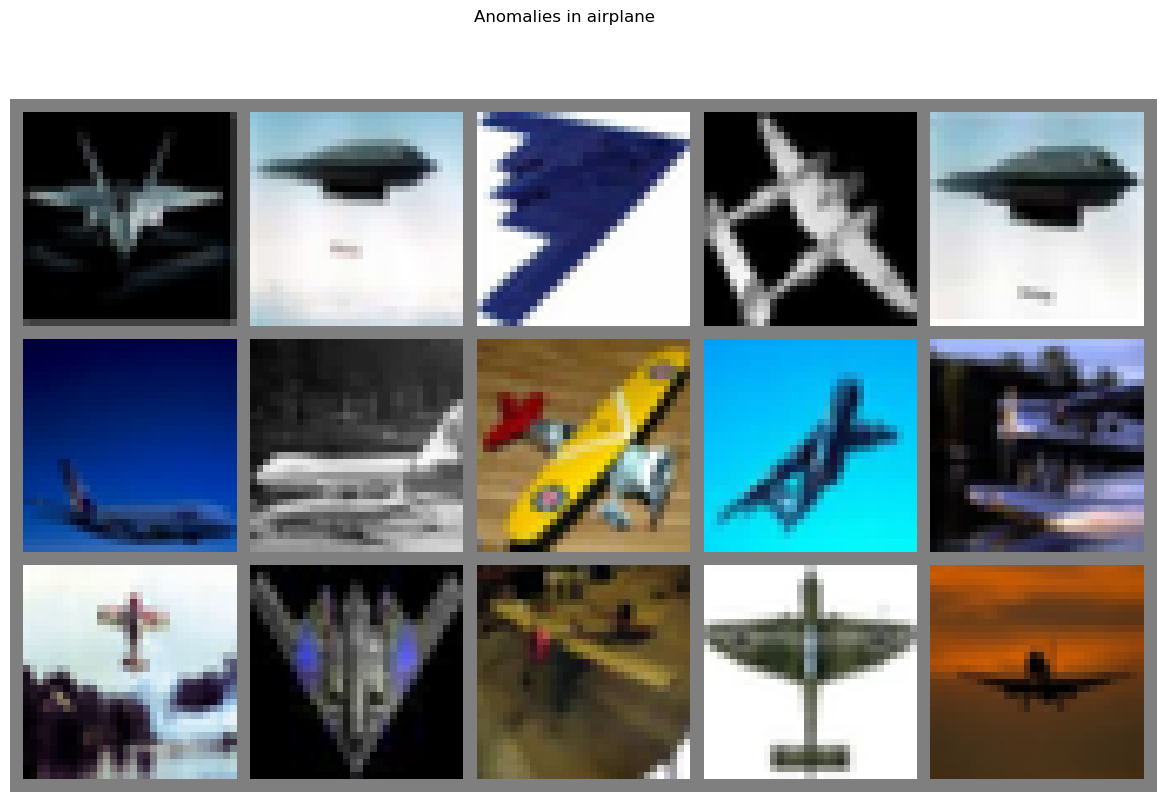

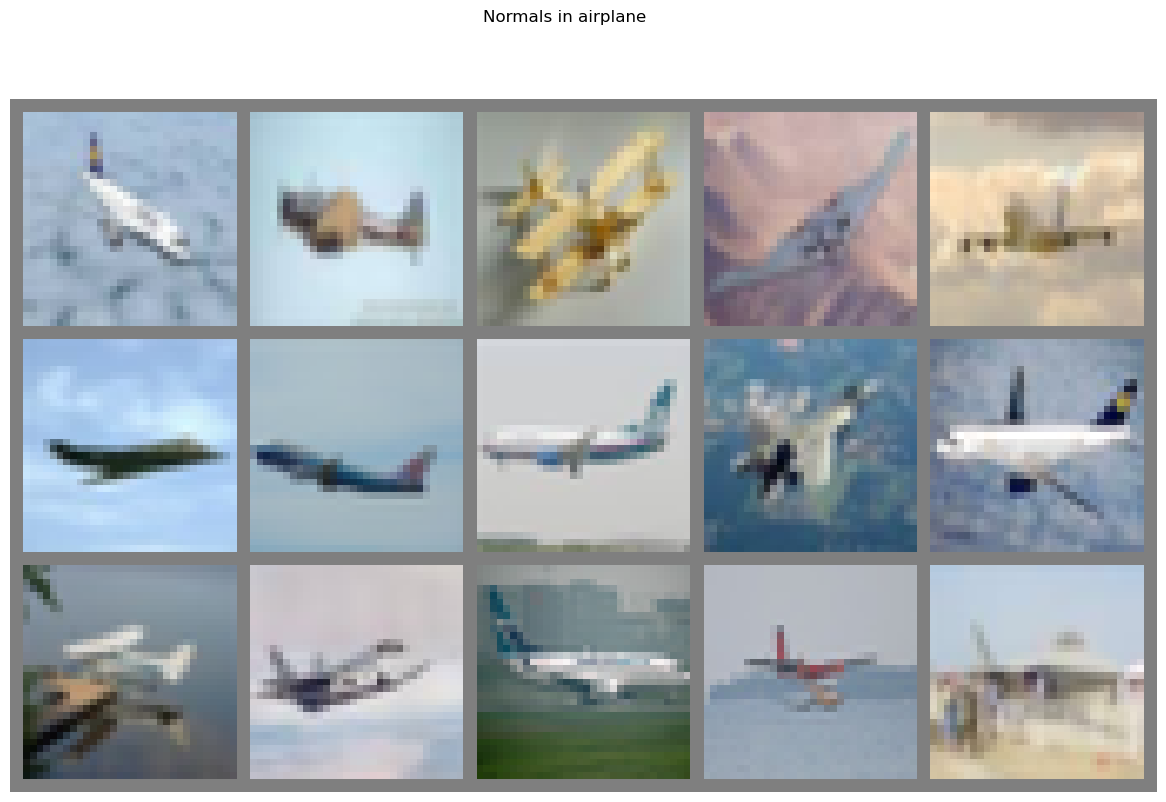

In [5]:
# Example usage:
detect_anomalies('airplane')